# Description

Using Structural Similarity Index(SSIM) to figure out what furniture suits a particular spot on the room

# Packages

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import json
from gensim.models import KeyedVectors

# Extract features

In [3]:
model_path = "GoogleNews-vectors-negative300.bin"
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)

## Image features

In [4]:
def extract_image_features(model, image_path):
  
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    try:
        image = Image.open(image_path).convert('RGB')
       
        processed_image = preprocess(image).numpy()
        processed_image = np.transpose(processed_image, (1, 2, 0))
        
        gray_image = cv2.cvtColor((processed_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        return gray_image
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

# Calculate similarity

In [5]:
def compute_SSI_similarity(image1, image2):
  
    try:
        similarity_score, _ = ssim(image1, image2, full=True)
        return similarity_score
    except Exception as e:
        print(f"Error computing SSIM: {str(e)}")
        return 0.0

In [6]:
def compute_cosine_similarity(input, furniture, model):
    
    with open('furn_metadata.json', 'r') as file:
        metadata = json.load(file)

    
    similarity = 0

    for each in ['style', 'room_type']:
        max_similarity = 0  
        attribute_values = metadata[furniture].get(each, [])
        
        for one in attribute_values:
                if one in model.key_to_index and input[each] in model.key_to_index:
                    vec1 = model[one].reshape(1, -1)
                    vec2 = model[input[each]].reshape(1, -1)
                    cos_sim = cosine_similarity(vec1, vec2)[0][0]
                    max_similarity = max(max_similarity, cos_sim)
                else:
                    max_similarity = max(max_similarity, 0.5)  

        similarity += max_similarity

    return similarity / 2  

In [7]:
def extract_furniture_features(model, furniture_dir):
   
    furniture_features = {}
    furniture_dir = Path(furniture_dir)
    
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.webp'}
    
    for img_path in furniture_dir.rglob('*'):
        if img_path.suffix.lower() in valid_extensions:
            features = extract_image_features(None, img_path) 
            if features is not None:
                furniture_features[img_path] = features
    
    return furniture_features

# Recommending function

In [8]:
def recommend_furniture(room_image_path, input,  furniture_dir, top_n, similarity_threshold=0.3):
    
    
    room_features = extract_image_features(None, room_image_path)  
    if room_features is None:
        return []
    
   
    furniture_features = extract_furniture_features(None, furniture_dir) 
    
    
    recommendations = []

    for furniture_path, features in furniture_features.items():
        furniture_name = str(os.path.basename(furniture_path)).split('.')[0]
        ssi = compute_SSI_similarity(room_features, features)
        cosine = compute_cosine_similarity(input, furniture_name, model=word_vectors)
        score = 0.65*cosine+0.35*ssi
        recommendations.append((furniture_path, ssi, cosine, score))
   
    recommendations.sort(key=lambda x: x[3], reverse=True)
    return recommendations[0:3]

# Visualize

In [9]:
def visualize_recommendations(room_image_path, recommendations):
   
    n_items = len(recommendations)
    if n_items == 0:
        print("No recommendations found!")
        return
    
   
    fig_width = min(15, 3 * (n_items + 1))
    fig_height = 5
    
    plt.figure(figsize=(fig_width, fig_height))
    
   
    plt.subplot(1, n_items + 1, 1)
    room_img = Image.open(room_image_path)
    plt.imshow(room_img)
    plt.title('Room Spot')
    plt.axis('off')
    
    
    for i, (furniture_path, ssi, cosine, score) in enumerate(recommendations, 2):
        plt.subplot(1, n_items + 1, i)
        furniture_img = Image.open(furniture_path)
        plt.imshow(furniture_img)
        plt.title(f'SSIM: {ssi:.2f} \n Cosine: {cosine:.2f} \n Final: {score:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Usage


Top Recommendations:
Furniture: white_armchair.png
Overall Score: 0.872

Furniture: yellow_armchair.png
Overall Score: 0.850

Furniture: light_gray_sofa.png
Overall Score: 0.844



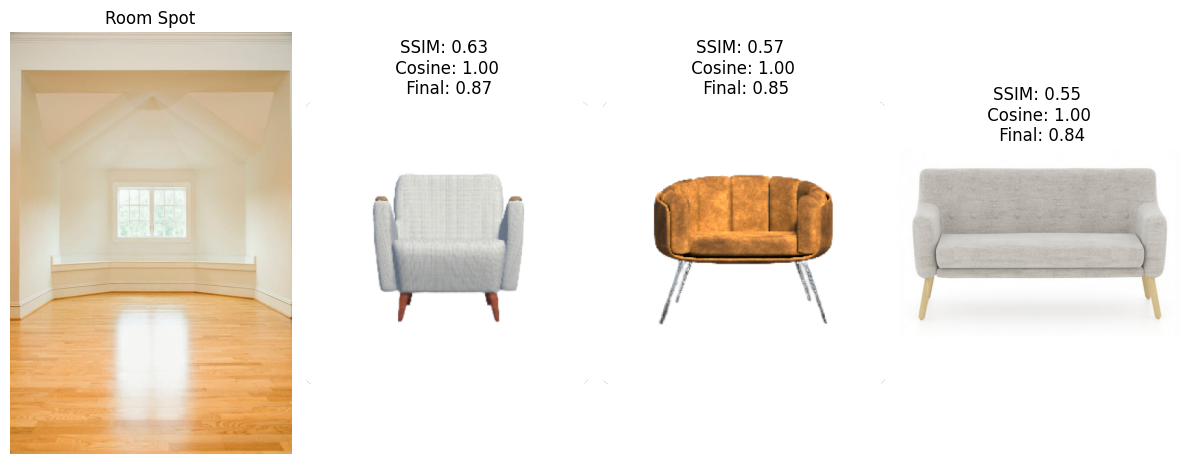

In [18]:
room_image_path = "empty_corner.jpg"
furniture_dir = "./furniture_models"

input = dict()
input['style']='minimalist'
input['room_type']='living'

    
    
recommendations = recommend_furniture(
        room_image_path=room_image_path,
        furniture_dir=furniture_dir,
        top_n=3,
        similarity_threshold=0 ,
        input=input
    )
    
   
print("\nTop Recommendations:")
for furniture_path, ssi, cosine, score in recommendations:
        print(f"Furniture: {furniture_path.name}")
        print(f"Overall Score: {score:.3f}\n")
    
   
visualize_recommendations(room_image_path, recommendations)